In [1]:
from Almanac.Data import get_weather_data
from Almanac.Data import get_frost_dates
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = get_weather_data("Chicago, IL", "2015-01-01", "2021-12-31")
df_future = get_weather_data("Chicago, IL", "2022-01-01", "2022-12-31")

In [3]:
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2015-01-01,-4.3,-8.3,0.0,0.0,0.0,240.0,25.5,NaN,1019.8,NaN
2015-01-02,-1.5,-6.7,2.2,0.0,0.0,NaN,7.8,NaN,1025.3,NaN
2015-01-03,1.6,-0.6,2.8,15.0,0.0,NaN,8.5,NaN,1013.7,NaN
2015-01-04,-3.7,-15.0,2.2,4.6,51.0,305.0,20.2,NaN,NaN,NaN
2015-01-05,-15.6,-18.3,-12.2,3.8,102.0,NaN,17.5,NaN,NaN,NaN


<Axes: xlabel='time'>

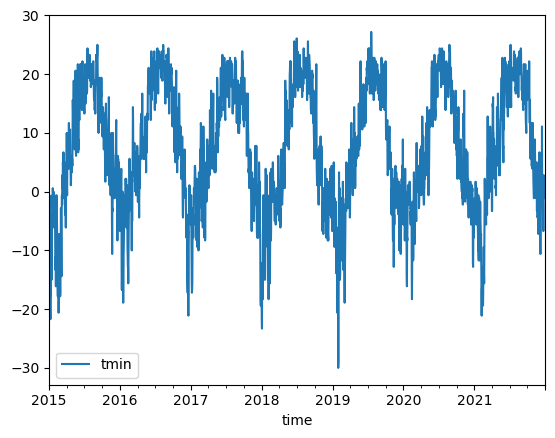

In [4]:
df.plot(y="tmin")

In [5]:
first, last = get_frost_dates(df)

In [6]:
f = pd.Series(first)
s = pd.Series(last)

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [94]:
decomp = seasonal_decompose(
    df["tmin"].resample("W").mean(),
    model="add",
    extrapolate_trend="freq",
    period=52,
)

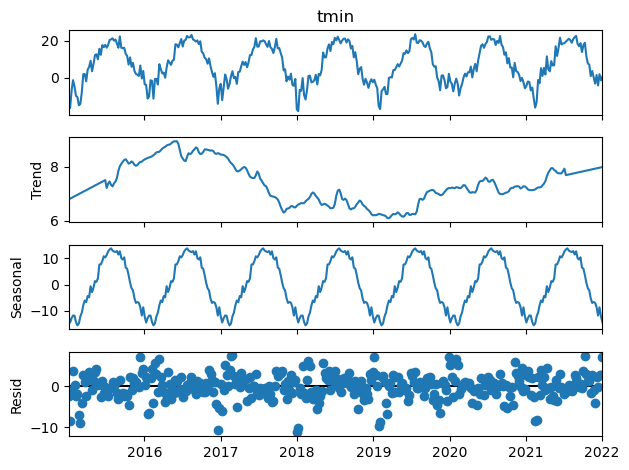

In [95]:
decomp.plot();

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [96]:
mod = SARIMAX(
    df["tmin"].resample("W").mean(),
    order=(3, 0, 0),
    seasonal_order=(0, 1, 1, 52),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
)

In [97]:
r = mod.fit()

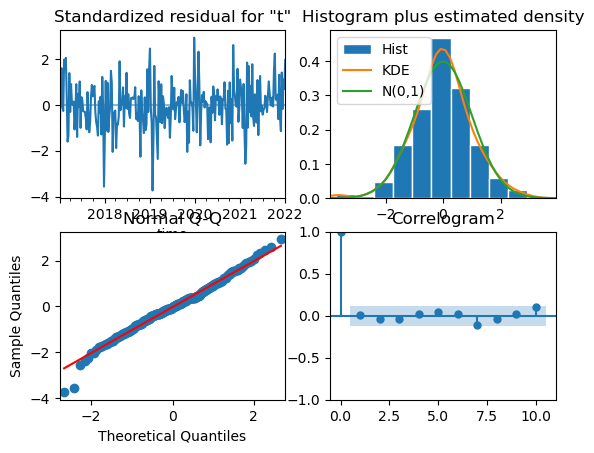

In [98]:
r.plot_diagnostics();

In [99]:
pred = r.get_prediction(start="2021-01-03", dynamic=False)

In [100]:
from sklearn.metrics import mean_squared_error

<Axes: xlabel='time'>

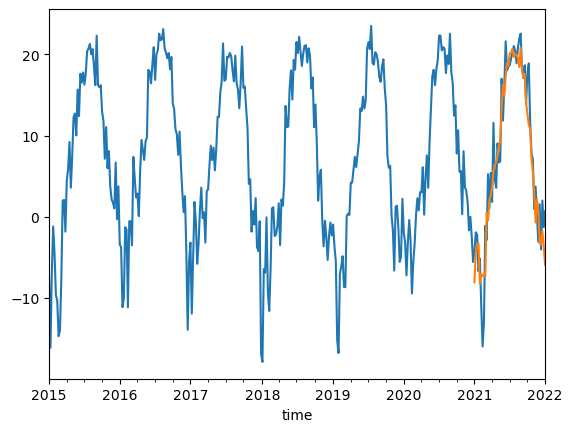

In [101]:
df["tmin"].resample("W").mean().plot()
pred.predicted_mean.plot()

In [102]:
mean_squared_error(
    df["tmin"].resample("W").mean()["2021-01-03":"2021-12-31"],
    pred.predicted_mean[0:52],
    squared=False,
)

3.311927811055153

In [50]:
type(pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

<Axes: >

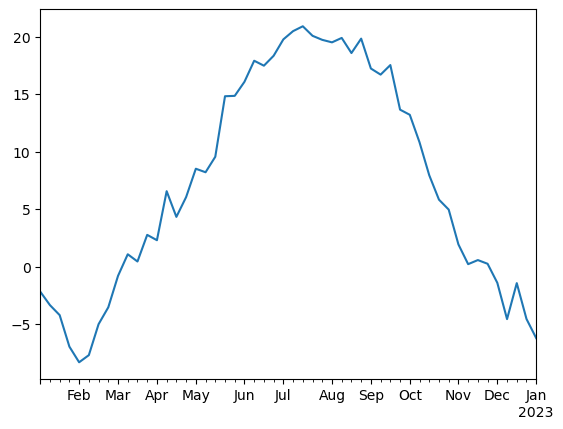

In [104]:
r.forecast("2022-12-31").plot()

<Axes: xlabel='time'>

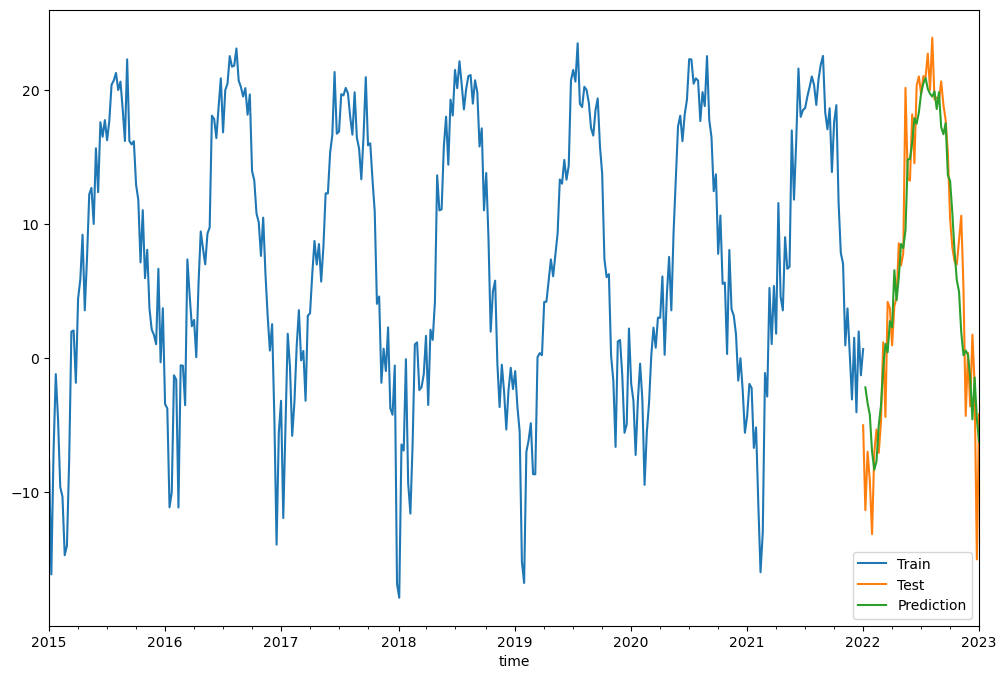

In [110]:
fig = plt.figure(figsize=(12, 8))
df["tmin"].resample("W").mean().plot(label="Train", legend=True)
df_future["tmin"].resample("W").mean().plot(label="Test", legend=True)
r.predict(start="2022-01-03", end="2022-12-31").plot(
    label="Prediction", legend=True
)

In [106]:
mean_squared_error(
    df_future["tmin"].resample("W").mean()[1:53],
    r.predict(start="2022-01-03", end="2022-12-31"),
    squared=False,
)

3.792170130132493

In [91]:
df_future["tmin"].resample("W").mean()

time
2022-01-02    -5.000000
2022-01-09   -11.328571
2022-01-16    -6.971429
2022-01-23    -9.142857
2022-01-30   -13.114286
2022-02-06    -7.042857
2022-02-13    -5.314286
2022-02-20    -7.057143
2022-02-27    -4.757143
2022-03-06     1.185714
2022-03-13    -4.371429
2022-03-20     4.200000
2022-03-27     3.728571
2022-04-03     0.957143
2022-04-10     3.885714
2022-04-17     4.542857
2022-04-24     8.571429
2022-05-01     6.914286
2022-05-08     7.857143
2022-05-15    20.157143
2022-05-22    13.414286
2022-05-29    13.242857
2022-06-05    18.185714
2022-06-12    14.542857
2022-06-19    20.328571
2022-06-26    21.014286
2022-07-03    19.685714
2022-07-10    21.028571
2022-07-17    20.971429
2022-07-24    22.714286
2022-07-31    20.014286
2022-08-07    23.900000
2022-08-14    19.300000
2022-08-21    19.442857
2022-08-28    19.185714
2022-09-04    20.642857
2022-09-11    18.885714
2022-09-18    17.771429
2022-09-25    15.314286
2022-10-02    10.385714
2022-10-09     8.257143
2022-10-16 

In [92]:
r.predict(start="2022-01-03", end="2022-12-31")

2022-01-09    -2.016395
2022-01-16    -3.153873
2022-01-23    -4.016887
2022-01-30    -6.722702
2022-02-06    -8.079680
2022-02-13    -7.493624
2022-02-20    -4.793419
2022-02-27    -3.293382
2022-03-06    -0.590566
2022-03-13     1.322941
2022-03-20     0.683760
2022-03-27     3.002576
2022-04-03     2.531360
2022-04-10     6.806466
2022-04-17     4.551669
2022-04-24     6.268334
2022-05-01     8.746984
2022-05-08     8.423720
2022-05-15     9.780063
2022-05-22    15.055340
2022-05-29    15.081443
2022-06-05    16.311798
2022-06-12    18.145771
2022-06-19    17.709081
2022-06-26    18.583919
2022-07-03    20.006471
2022-07-10    20.719226
2022-07-17    21.138063
2022-07-24    20.311854
2022-07-31    19.960986
2022-08-07    19.733934
2022-08-14    20.130252
2022-08-21    18.825337
2022-08-28    20.077592
2022-09-04    17.470938
2022-09-11    16.936802
2022-09-18    17.760214
2022-09-25    13.889893
2022-10-02    13.445303
2022-10-09    11.075918
2022-10-16     8.181288
2022-10-23     6